# Introduction

# Data Access

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [19]:
# pour le filtrage des warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


Les parties s’appliquent sur l’ensemble d’entraînement (donc **DailyDelhiClimateTrain.csv**)

In [3]:
data_dir=Path("./Data/")
data=pd.read_csv( 
    data_dir / "DailyDelhiClimateTrain.csv",
    index_col ="date", #on set la colonne data entant que index.
)
data

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [4]:
#verifier les types des données:
data.dtypes

meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

nous allons convertir la colonne date, en format de date

In [5]:
#verifier que le dataset ne contient pas de contenu vide.
data.dropna().shape

(1462, 4)

 et la variable **meantemp**


On va travailler avec le Dataframe **df**.

In [28]:
df=data[["meantemp"]]
df.head(5)

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


# Partie 1

 En utilisant la colonne de température moyenne; soit la meantemp, faites une analyse :
- Time Step (La régression de la température moyenne en fonction du temps)

In [29]:
#nous créons la colonne time en se basant sur les index de date, afin de simplifier la représentation.
#ainsi que la regression.
df["Time"]=np.arange(len(df.index))
df.head(5)

,meantemp,Time
date,,
2013-01-01,10.000000,0
2013-01-02,7.400000,1
2013-01-03,7.166667,2
2013-01-04,8.666667,3
2013-01-05,6.000000,4


Text(0.5, 1.0, 'Time Plot of mean Temperature')

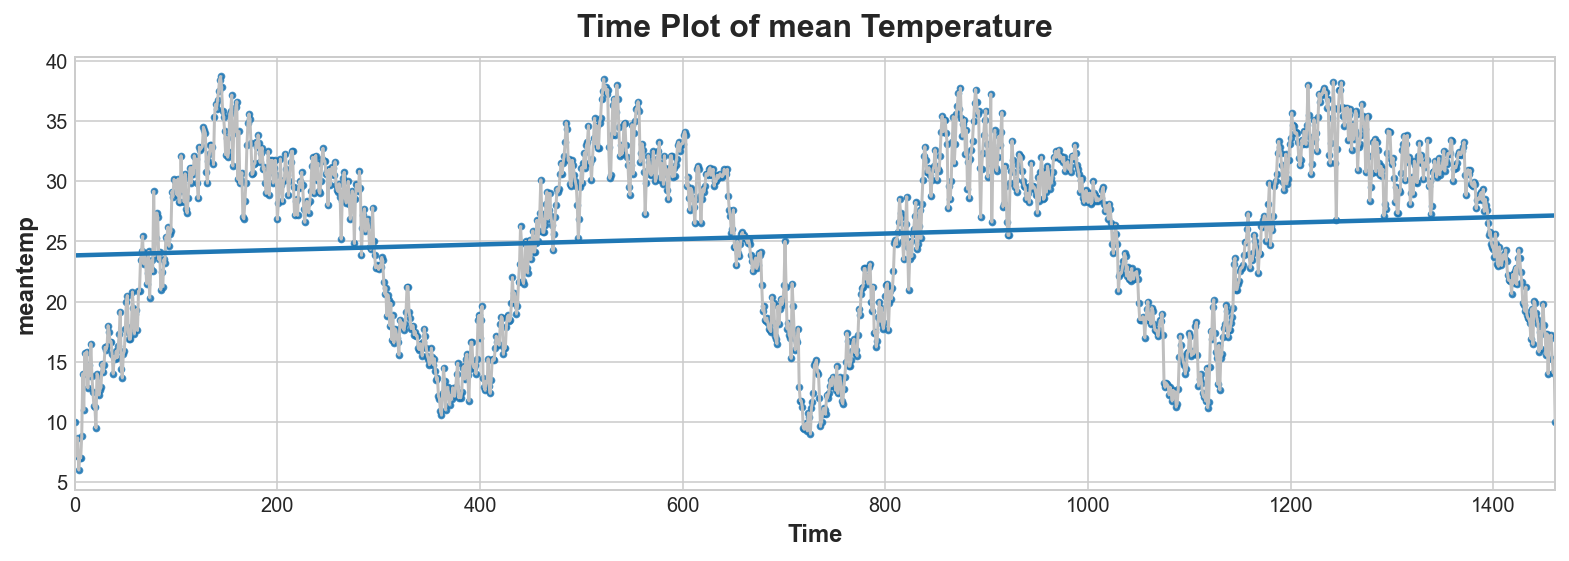

In [30]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'meantemp', data=df, color='0.75') # on set la couleur des données pour mieux les visualiser
ax = sns.regplot(x='Time', y='meantemp', data=df, ci=None, scatter_kws={'s': 8}) # on applique la ligne de regression dessus.
ax.set_title('Time Plot of mean Temperature') # on set le titre.

In [41]:
# données d'entraînement
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'meantemp']  # target

# entraînement du modèle
model = LinearRegression()
model.fit(X, y)

# stockage des valeurs ajustées sous la forme d'une série chronologique
y_pred = pd.Series(model.predict(X), index=X.index)

# obtention de l'équation de la droite
print(f'Y = {model.coef_[0]:.2f} * X + {model.intercept_:.2f}')

Y = 0.00 * X + 23.84


Time step permet de modéliser la dépendance au temps. Selon l'équation de la droite on peut en déduire qu'il n'y a pas de relation linéaire entre la variable temps et la variable target (à savoir la température moyenne). Il s'agit d'une fonction constante. Il n'y a donc pas de tendance qui s'extrait à partir d'une fonction linéaire. Si l'on regarde le graphique en revanche on peut voir une fluctuation selon des cycles qui pourraient évoquer une saisonnalité.

- Lag Feature (La régression en fonction de l’instant n-1)

In [43]:
# on creer le shift de la colonne Lag feature
df["Lag_1"]=df["meantemp"].shift(1)
df = df.reindex(columns=['meantemp', 'Lag_1'])
df.head(5)

,meantemp,Lag_1
date,,
2013-01-01,10.000000,NaN
2013-01-02,7.400000,10.000000
2013-01-03,7.166667,7.400000
2013-01-04,8.666667,7.166667
2013-01-05,6.000000,8.666667


Text(0.5, 1.0, 'Lag Plot of Hardcover Sales')

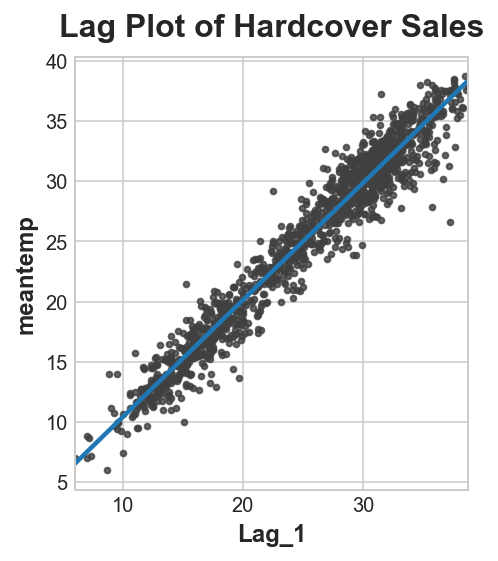

In [44]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='meantemp', data=df, ci=None, scatter_kws={'s': 8, 'color':'0.25'})
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales')

In [47]:
# données d'entraînement
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'meantemp']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# entraînement du modèle
model = LinearRegression()
model.fit(X, y)

# stockage des valeurs ajustées sous la forme d'une série chronologique
y_pred = pd.Series(model.predict(X), index=X.index)

# obtention de l'équation de la droite
print(f'Y = {model.coef_[0]:.2f} * X + {model.intercept_:.2f}')

Y = 0.97 * X + 0.66


Lag feature permet de modéliser la dépendance sérielle : c'est-à-dire le fait qu'une observation peut être prédite à partir de l'observation précédente (n-1). D'après l'équation de la droite il existe une relation linéaire entre la variable target et ses valeurs à l'instant n-1 (auto-correlation). On peut en conclure que les valeurs moyennes de températures passées sont un bon prédicteur de la variable meantemp.

# Partie 2 (TODO)

En rappliquant tous les processus vus en cours, analyser la tendance :
- Tracer des graphes de moyennes glissantes (moving average)
- Utiliser les méthodes de Trend Engineering par le biais de la bibliothèque Deterministic Process afin de déterminer la tendance optimale.
- Faire des graphe pour la tendance linéaire, quadratique, cubique. Tester pour d’autres dimensions.
- Faire un forecast pour 15 jours futurs
- Enlevez la composante de tendance de votre série.


# Partie 3 (TODO)

En réitérant les mécanismes vus en cours, étudier la saisonnalité de la série temporelle:
- Réaliser des Seasonal Plots
- Utiliser les Fourier Features et analyser le périodogramme
- Utiliser les Deterministic Process avec le CalendarFourier afin de détecter la saisonnalité
- Appliquer ces méthodes sur la variable après élimination de la composante de tendance
- Faire un forecast pour 15 jours futurs
- Eliminer la saisonnalité de la composante privée de tendance

# Partie 4 (TODO)

En réitérant les processus vus en cours; analyser les cycles par le biais des Lagged Features:
- Tracer les courbes d’autocorrelation partielle
- Identifier les corrélations avec les Lags passés
- Analyser les cycles par le biais de Lags passés
- Faire un forecast pour 15 jours futurs
- Soustraire les cycles de la composante sans tendance ni saisonnalité

# Partie 5 (TODO)

Appliquer les processus hybrides